# Roteiro Levenberg-Marquadt

Esse código é um protótipo de função para a implementação do algoritmo de Levenberg-Marquadt, o qual é utilizado para estimar parâmetros não-lineares. 

\begin{equation}
\Gamma (\textbf{m}) = \Psi (\textbf{m}) + \sum\limits^{6}_{j=1}\alpha_{j}\varphi_{j}(\textbf{m})
\end{equation}

In [35]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as npt
import cPickle as pickle

from fatiando.gridder import regular
from copy import deepcopy
from __future__ import division
from fatiando import mesher, gridder, utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.gravmag import prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv
from fatiando.constants import CM, T2NT
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
import mag_polyprism_functions as mfun
import polyprism_tests as tests
#% matplotlib inline

# Entrada

### Gerando os parâmetros verdadeiros

In [37]:
with open('../data/cylinder_model.pickle') as w:
        cylinder_model = pickle.load(w)
        

### Pontos de observação

In [38]:
with open('../data/regular_grid.pickle') as w:
        regular_grid = pickle.load(w)
        

# Gerando os dados preditos

In [39]:
with open('../data/cylinder_data.pickle') as w:
        cylinder_data = pickle.load(w)

### Parâmetros exigidos durante a inversão

In [40]:
a1 = 1.00001   # adjacent radial distances within each prism
a2 = 1.00001    # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.00001   # vertically adjacent origins
a6 = 10.00000001   # zero order Tikhonov on adjacent radial distances

In [41]:
M = 50 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters
dz = 300.

# limits for parameters in meters
rmin = 10.
rmax = 900.
x0min = -1000.
x0max = 1000.
y0min = -1000.
y0max = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max)

itmax = 30
itmax_marq = 15
epsilon = 1.0e-5     # convergence criterion

deltax = 0.01*np.max(x0max)
deltay = 0.01*np.max(y0max)
deltar = 0.01*np.max(rmax)# increment of derivatives
m_out = np.zeros(M + 2)  # outcropping body parameters

inc = cylinder_model['inc']
dec = cylinder_model['dec']
z0 = cylinder_model['z0']
#dz = cylinder_model['dz']
props = cylinder_model['props']
dobs = cylinder_data['data_noise']
xp = regular_grid['xp']
yp = regular_grid['yp']
zp = regular_grid['zp']
N = regular_grid['N']

rin = np.linspace(100.,150.,M)
m0 = np.hstack((rin, np.zeros(2)))
m0 = np.resize(m0, P) # inicial parameters vector
model0, d0, res0, phi0 = mfun.prism_d_res_phi(xp, yp, zp, m0, z0, dz, M, L, props, dobs, inc, dec)
#model0 = mfun.param2polyprism(m0, M, L, cylinder_model['z0'], dz, cylinder_model['props']) # list of classes of prisms
#d0 = polyprism.tf(xp, yp, zp, model0, inc, dec) # predict data
#res = dobs - d0

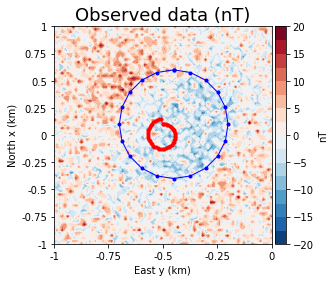

In [42]:
plt.title("Observed data (nT)", fontsize = 18)
plt.axis('scaled')
nlevels = mpl.contourf(regular_grid['yp'], regular_grid['xp'], cylinder_data['data_noise'],\
                       regular_grid['shape'], 15, cmap='RdBu_r')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
plt.colorbar(pad=0.01, aspect=20, shrink=1.).set_label('nT')
for p in cylinder_model['prisms']:
    mpl.polygon(p, '.-b', xy2ne=True)
for p in model0:
    mpl.polygon(p, '.-r', xy2ne=True)
mpl.m2km()
plt.savefig('observed_data.png', dpi=300)
plt.show()

In [43]:
#G = mfun.Jacobian_tf(xp, yp, zp, model0, M, L, deltax, deltay, deltar, inc, dec)
#H = 2*np.dot(G.T, G)/N
#th = np.trace(H)/P

In [44]:
#%lprun -f mfun.Jacobian_tf mfun.Jacobian_tf(xp, yp, zp, model0, M, L, deltax, deltay, deltar, inc, dec)

In [45]:
#print th

In [46]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 50.
dlamb = 2.      # step for Marquadt's parameter

#alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = mfun.norm_regul_param(M, L, th, m_out, a1, a2, a3, a4, a5, a6)
#alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = mfun.norm_regul_param(M, L, 1., m_out, a1, a2, a3, a4, a5, a6)


In [47]:
phi0 = np.sum(res0*res0)/N
phi_list = [phi0]
    
i,j = np.diag_indices(P)
for it in range(itmax):
    #bounds = [-3000., 3000., -3000., 3000., -1000.0, 4000.]

    #red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
    #white, black = (1, 1, 1), (0, 0, 0),
    #scene = myv.figure()
    #myv.polyprisms(cylinder_model['prisms'], 'magnetization', color=blue, linewidth=1., style='wireframe', opacity=.3)
    #myv.polyprisms(model0, 'magnetization', color=red, linewidth=3.5)

    #ax = myv.axes(myv.outline(bounds), ranges=[t * 0.001 for t in bounds])
    #ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (cm)', 'y (cm)', 'z (cm)'
    #ax.axes.font_factor = 1.5
    #scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
    #scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
    #scene.scene.camera.view_angle = 30.0
    #scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
    #scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
    #scene.scene.camera.compute_view_plane_normal()

    #myv.wall_bottom(ax.axes.bounds, opacity=0.2)
    #myv.wall_north(ax.axes.bounds)
        
    #myv.savefig('bolacha'+`it`+'.png')
    
    mt = mfun.trans_parameter2(m0, M, L, mmax, mmin)
        
    # Jacobian matrix
    G = mfun.Jacobian_tf(xp, yp, zp, model0, M, L, deltax, deltay, deltar, inc, dec)
    
    # Hessian matrix
    H = 2.*np.dot(G.T, G)/N
    
    #print th
    #print np.diag(H)
    
    th = np.trace(H)/P
    
    alpha1 = a1*th
    alpha2 = a2*th
    alpha3 = a3*th
    alpha4 = a4*th
    alpha5 = a5*th
    alpha6 = a6*th
    
    #prec = np.diagonal(H).copy()
    #mask = prec < 1e-10
    #prec[mask] = 1e-10
    #H[:,j] /= prec    

    H = mfun.Hessian_phi_1(M, L, H, alpha1)
    #H = mfun.Hessian_phi_2(M, L, H, alpha2)
    #H = mfun.Hessian_phi_3(M, L, H, alpha3)
    #H = mfun.Hessian_phi_4(M, L, H, alpha4)
    #H = mfun.Hessian_phi_5(M, L, H, alpha5)
    H = mfun.Hessian_phi_6(M, L, H, alpha6)
    
    # gradient vector
    grad = -2.*np.dot(G.T, res0)/N

    grad = mfun.gradient_phi_1(M, L, grad, alpha1)
    #grad = mfun.gradient_phi_2(M, L, grad, alpha2)
    #grad = mfun.gradient_phi_3(M, L, grad, m_out, alpha3)
    #grad = mfun.gradient_phi_4(M, L, grad, m_out[-2:], alpha4)
    #grad = mfun.gradient_phi_5(M, L, grad, alpha5)
    grad = mfun.gradient_phi_6(M, L, grad, alpha6)
    
    # positivity matrix diagonal
    T = ((mmax - m0 + 1e-10)*(m0 - mmin + 1e-10))/(mmax - mmin)*np.identity(P)
    
    D = np.diag(1./np.sqrt(np.diag(np.dot(H,T))))
    
    DHTD = np.dot(np.dot(D, np.dot(H,T)), D)
    
    for it_marq in range(itmax_marq): 

        #S = H.copy()
        #S = H[:,:]
        #S[i,:] *= T
        #S[i,j] += lamb

        delta_mt = np.dot(D,np.linalg.solve(DHTD + lamb*np.identity(mt.size), -np.dot(D, grad)))
        #print np.min(delta_mt)
        
        # criar teste pra esta função
        m_est = mfun.trans_inv_parameter2(mt + delta_mt, M, L, mmax, mmin)
        #m_est = m0 + delta_mt

        model_est, d_fit, res, phi = mfun.prism_d_res_phi(xp, yp, zp, m0, z0, dz, M, L, props, dobs, inc, dec)
        #model_est = mfun.param2polyprism(m_est, M, L, cylinder_model['z0'], dz, cylinder_model['props'])

        #d_fit = polyprism.tf(xp, yp, zp, model_est, inc, dec)
        #res = dobs - d_fit
        phi = np.sum(res*res)/N
        #print phi
        phi += mfun.phi_1(M, L, m_est, alpha1) +\
                mfun.phi_3(M, L, m_est, m_out, alpha3) + mfun.phi_4(M, L, m_est, m_out[-2:], alpha4) + \
                mfun.phi_6(M, L, m_est, alpha6)
        #print phi
        dphi = phi - phi0
        #print dphi
        
        print '%3d %.5e %3d %.e' % (it, phi, it_marq, lamb)
        
        if (dphi > 0.):
            lamb *= dlamb
        else:
            if lamb/dlamb < 1e-15:
                lamb = 1e-15
            else:
                lamb /= dlamb
            break
            
    if (abs(dphi/phi0) < epsilon):
        break
    else:
        d0 = d_fit.copy()
        m0 = m_est.copy()
        model0 = model_est
        res0 = res.copy()
        phi0 = phi
        phi_list.append(phi)

  0 3.43817e+01   0 5e+01
  0 3.43653e+01   1 1e+02
  0 3.43570e+01   2 2e+02
  0 3.43528e+01   3 4e+02
  0 3.43507e+01   4 8e+02
  0 3.43496e+01   5 2e+03
  0 3.43491e+01   6 3e+03
  0 3.43488e+01   7 6e+03
  0 3.43487e+01   8 1e+04
  0 3.43486e+01   9 3e+04
  0 3.43486e+01  10 5e+04
  0 3.43486e+01  11 1e+05
  0 3.43486e+01  12 2e+05
  0 3.43486e+01  13 4e+05
  0 3.43486e+01  14 8e+05
  1 3.43486e+01   0 2e+06
  1 3.43486e+01   1 3e+06
  1 3.43486e+01   2 7e+06
  1 3.43486e+01   3 1e+07


In [48]:
for i, (mv, mm) in enumerate(zip(m0,mmin)):
    if mv<=mm:
        print '%.15e,%.e' % (mv,i)

In [49]:
print delta_mt

[  1.71463324e-08   1.20706969e-08   1.14889529e-08   1.10151709e-08
   1.07010729e-08   1.05830432e-08   1.06798374e-08   1.09935309e-08
   1.15101300e-08   1.21936791e-08   1.29785188e-08   1.37768625e-08
   1.45079810e-08   1.51285291e-08   1.56385217e-08   1.60611472e-08
   1.64160486e-08   1.67041868e-08   1.69081812e-08   1.70022717e-08
   1.69634052e-08   1.67759582e-08   1.64286412e-08   1.59111029e-08
   1.52196720e-08   1.43740101e-08   1.34359542e-08   1.25135241e-08
   1.17351106e-08   1.11965798e-08   1.09147410e-08   1.08364514e-08
   1.09045416e-08   1.11128911e-08   1.14986132e-08   1.20917902e-08
   1.28759426e-08   1.37970741e-08   1.48072646e-08   1.58802722e-08
   1.69774007e-08   1.80204428e-08   1.89148658e-08   1.95939090e-08
   2.00353304e-08   2.02423074e-08   2.02143894e-08   1.99346184e-08
   1.93841775e-08   1.50140168e-08   2.98484255e-09  -7.50209353e-10]


In [50]:
res_norm = (res - np.mean(res))/np.std(res)

In [51]:
np.mean(res_norm), np.std(res_norm)

(0.0, 1.0)

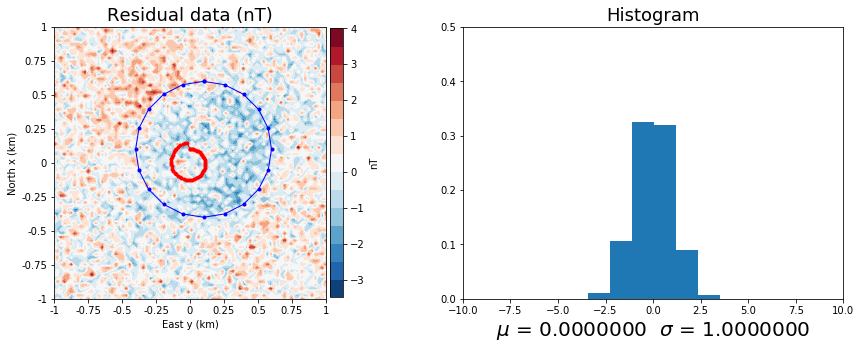

In [52]:
#ddif = dobs - d0
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Residual data (nT)", fontsize = 18)
plt.axis('scaled')
nlevels = mpl.contourf(yp, xp, res_norm,regular_grid['shape'], 15, cmap='RdBu_r')
plt.xlabel('East y (km)')
plt.ylabel('North x (km)')
plt.colorbar(pad=0.01, aspect=20, shrink=0.99).set_label('nT')
for p in cylinder_model['prisms']:
    mpl.polygon(p, '.-b', xy2ne=True)
for p in model_est:
    mpl.polygon(p, '.-r', xy2ne=True)
mpl.m2km()
#plt.savefig('residual_data.png', dpi=300)
plt.subplot(1,2,2)
#plt.axis('auto')
plt.title('Histogram', fontsize = 18)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
plt.hist(res_norm,bins=nbins, normed=True)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.savefig('fit_hist_cylinder.png', dpi=300)
plt.show()

In [53]:
phi_list[1]

34.348576895525746

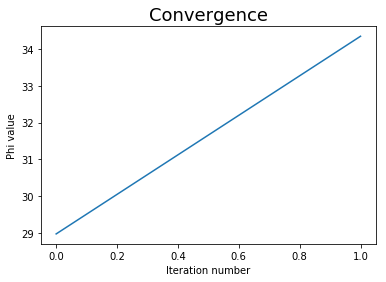

In [54]:
plt.title('Convergence', fontsize = 18)
plt.xlabel('Iteration number')
plt.ylabel('Phi value')
plt.plot(phi_list)
plt.savefig('convergence_cylinder.png', dpi=300)
plt.show()

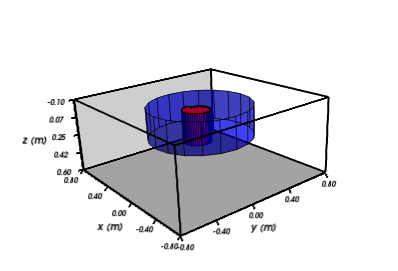

In [55]:
bounds = [-800., 800., -800., 800., -100., 600.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
myv.polyprisms(cylinder_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5)
myv.polyprisms(model_est, 'magnetization', color=red, linewidth=1.)

ax = myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds])
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (m)', 'y (m)', 'z (m)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
scene.scene.camera.compute_view_plane_normal()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
myv.savefig('bolacha_cylinder.png')
myv.show()

img(filename='bolacha_cylinder.png')

In [56]:
# limits for parameters in meters
rmin = 10.
rmax = 6000.
x0min = -5000.
x0max = 5000.
y0min = -5000.
y0max = 5000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max)

In [57]:
print alpha6

6.78505952719e-06


In [58]:
p = np.linspace(-5000., 5000.,P)
pt = - np.log((x0max - p)/(p - x0min))

/home/leonardo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/leonardo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [59]:
print pt

[       -inf -3.91202301 -3.19867312 -2.77258872 -2.46385324 -2.21920348
 -2.01490302 -1.83827948 -1.68175857 -1.54044504 -1.41098697 -1.29098418
 -1.178655   -1.0726368  -0.97186058 -0.87546874 -0.78275934 -0.69314718
 -0.6061358  -0.52129692 -0.43825493 -0.35667494 -0.27625338 -0.19671029
 -0.11778304 -0.03922071  0.03922071  0.11778304  0.19671029  0.27625338
  0.35667494  0.43825493  0.52129692  0.6061358   0.69314718  0.78275934
  0.87546874  0.97186058  1.0726368   1.178655    1.29098418  1.41098697
  1.54044504  1.68175857  1.83827948  2.01490302  2.21920348  2.46385324
  2.77258872  3.19867312  3.91202301         inf]


In [60]:
pi = x0min + (x0max - x0min)/(1+np.exp(-pt))

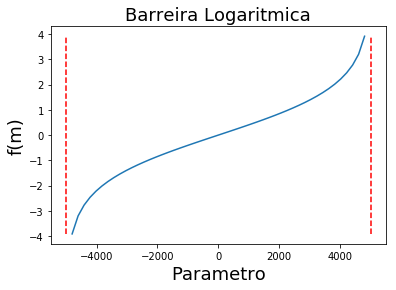

In [61]:
plt.title('Barreira Logaritmica', fontsize = 18)
plt.xlabel('Parametro', fontsize = 18)
plt.ylabel('f(m)', fontsize = 18)
plt.plot(pi,pt)
plt.plot(np.zeros(P)+5000., pt, 'r--')
plt.plot(np.zeros(P)-5000., pt, 'r--')
plt.savefig('bar_t.png', dpi=300)
plt.show()

In [62]:
print pi

[-5000.         -4803.92156863 -4607.84313725 -4411.76470588 -4215.68627451
 -4019.60784314 -3823.52941176 -3627.45098039 -3431.37254902 -3235.29411765
 -3039.21568627 -2843.1372549  -2647.05882353 -2450.98039216 -2254.90196078
 -2058.82352941 -1862.74509804 -1666.66666667 -1470.58823529 -1274.50980392
 -1078.43137255  -882.35294118  -686.2745098   -490.19607843  -294.11764706
   -98.03921569    98.03921569   294.11764706   490.19607843   686.2745098
   882.35294118  1078.43137255  1274.50980392  1470.58823529  1666.66666667
  1862.74509804  2058.82352941  2254.90196078  2450.98039216  2647.05882353
  2843.1372549   3039.21568627  3235.29411765  3431.37254902  3627.45098039
  3823.52941176  4019.60784314  4215.68627451  4411.76470588  4607.84313725
  4803.92156863  5000.        ]


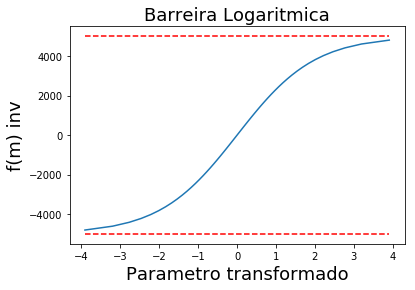

In [63]:
plt.title('Barreira Logaritmica', fontsize = 18)
plt.xlabel('Parametro transformado', fontsize=18)
plt.ylabel('f(m) inv', fontsize=18)
plt.plot(pt,p)
plt.plot(pt, np.zeros(P)+5000., 'r--')
plt.plot(pt, np.zeros(P)-5000., 'r--')
plt.savefig('bar_ti.png', dpi=300)
plt.show()

In [64]:
c = mfun.Hessian_phi_6(3, 2, np.zeros((10,10)), 1.)

In [65]:
c = np.dot(c,c)

In [66]:
np.dot(c, np.ones(10))

array([ 1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.])

In [67]:
m = np.ones(15)

In [68]:
P = 3*(3 + 2)

m6 = m.copy()

# extracting the non-zero diagonals
d0 = mfun.diags_phi_6(3, 3, .5)

# calculating the product between the diagonals and the slices of m
m6 = m*d0
print m6, m
phi_6 = np.dot(m6, m)
print phi_6

[ 0.5  0.5  0.5  0.   0.   0.5  0.5  0.5  0.   0.   0.5  0.5  0.5  0.   0. ] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
4.5


# Algoritmo Levenberg-Marquadt

1- Iteração $k=0$: chute inicial $\mathbf{m}_0$ em que todos os elementos satisfaçam os vínculos de desigualdade e um valor real positivo grande para $\lambda$

2) Calcula os parâmetros transformados $\breve{\mathbf{m}}_k$

Os parâmetros transformados são calculados a partir da equação:

\begin{equation}
\breve{m}_i = f(m_i) = - \ln\left(\frac{m_{i\, max} - m_i}{m_i - m_{i\, min}}\right)
\end{equation}

A transformação inversa dos parâmetros é dada pela equação:

\begin{equation}
m_i = f^{-1}(\breve{m}_i) = m_{i\, min} + \left(\frac{m_{i\, max} - m_{i\, min}}{1 + e^{-\breve{m}_i}}\right)
\end{equation}

3) laço externo: calcula $\nabla^2\Gamma (\hat{\mathbf{m}}_k)$, $\nabla\Gamma (\hat{\mathbf{m}}_k)$ e $T(\hat{\mathbf{m}}_k)$:

a) laço interno: calcula $\Delta \breve{\mathbf{m}}_k$ solucionando o sistema linear abaixo

\begin{equation}
\left[\nabla^2\Gamma (\hat{\mathbf{m}}_k)\mathbf{T}(\hat{\mathbf{m}}_k) + \lambda \mathbf{I} \right] \Delta\breve{\mathbf{m}}_k \approx - \nabla \Gamma (\hat{\mathbf{m}}_k)
\end{equation}

onde $\mathbf{T}(\hat{\mathbf{m}}_k)$ é uma matriz diagonal
\begin{equation}
[\mathbf{T}(\hat{\mathbf{m}}_k)]_{ii} = \frac{(m_{i\, max} - m_i)(m_i - m_{i\, min})}{(m_{i\, max} - m_{i\, min})}
\end{equation}

b) calcula $\breve{\mathbf{m}}_{k+1} = \breve{\mathbf{m}}_k + \Delta\breve{\mathbf{m}}_k$

c) computa $\hat{\mathbf{m}}_{k+1}$

d) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ 

   i $\lambda = \lambda\cdot d\lambda$

   ii retorne para 3)a)

e) $\lambda = \lambda/d\lambda$

4) Enquanto $\Gamma (\hat{\mathbf{m}}_{k+1})<\Gamma (\hat{\mathbf{m}}_k)$ e $\frac{|\Gamma (\hat{\mathbf{m}}_{k+1})- \Gamma (\hat{\mathbf{m}}_k)|}{|\Gamma (\hat{\mathbf{m}}_k)|}>\varepsilon$

a) $k=k+1$

b) Retorne para etapa 2)